References

In [ ]:
## Reference from https://www.kaggle.com/code/gcmadhan/amazon-stock-prediction-nn-fbprophet
## For EDA Section

## Reference from Week 4 Tutorial Codes

# Libraries Importing and Cleaning Data

In [ ]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from datetime import date

In [ ]:
# Set graphics standards
sns.set()

In [ ]:
# Get current workdirectory
os.getcwd()

In [ ]:
# Dates for train, val, test sets
train_start_date = "2015-04-28"
train_end_date   = "2017-12-31"

val_start_date   = "2018-01-03"
val_end_date     = "2018-12-31"

test_start_date  = "2019-01-02"
test_end_date    = "2020-01-31"

In [ ]:
# Read csv with pd
df_amzn = pd.read_csv("AMZN.csv", header=0)
df_fb = pd.read_csv("FB.csv", header=0)
df_intc = pd.read_csv("INTC.csv", header=0)

In [ ]:
# Change Date from string to datetime
df_amzn["Date"] = pd.to_datetime(df_amzn["Date"], dayfirst=True)
df_fb["Date"] = pd.to_datetime(df_fb["Date"], dayfirst=True)
df_intc["Date"] = pd.to_datetime(df_intc["Date"], dayfirst=True)

# Set "Date" as index column
df_amzn.set_index("Date", inplace=True)
df_fb.set_index("Date", inplace=True)
df_intc.set_index("Date", inplace=True)

<ipython-input-6-bfdb4b9a1d37>:3: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_fb["Date"] = pd.to_datetime(df_fb["Date"], dayfirst=True)


In [ ]:
# Check df
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-02-13,378.410004,383.000000,377.010010,381.829987,381.829987,3475100
2015-02-17,377.720001,379.989990,372.670013,375.429993,375.429993,3673200
2015-02-18,373.779999,376.739990,372.850006,373.369995,373.369995,2650600
2015-02-19,373.489990,381.880005,373.429993,379.000000,379.000000,2953800
2015-02-20,378.619995,383.700012,375.839996,383.660004,383.660004,3258000


# Exploratory Data Analysis

## Adjusted close price for 3 stocks

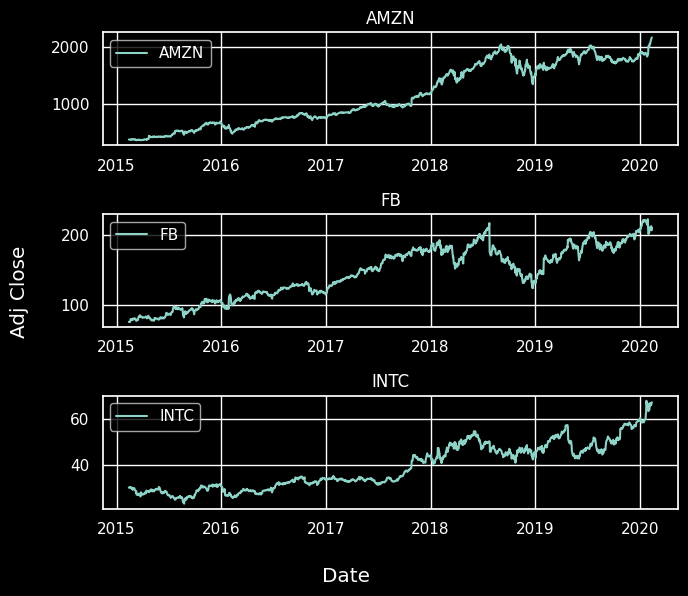

In [ ]:
# Create time series scatterplot of adjusted closed prices of the three stocks

plt.style.use('dark_background')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 6))

data_frames = [df_amzn, df_fb, df_intc]
ticker_symbol = ['AMZN', 'FB', 'INTC']

for ax, df, label in zip([ax1, ax2, ax3], data_frames, ticker_symbol):
    ax.plot(df.groupby('Date')['Adj Close'].sum(), label=label)
    ax.set_title(label)
    ax.legend(loc='upper left')

fig.supxlabel('Date')
fig.supylabel('Adj Close')

plt.tight_layout()

## Volume of 3 stocks

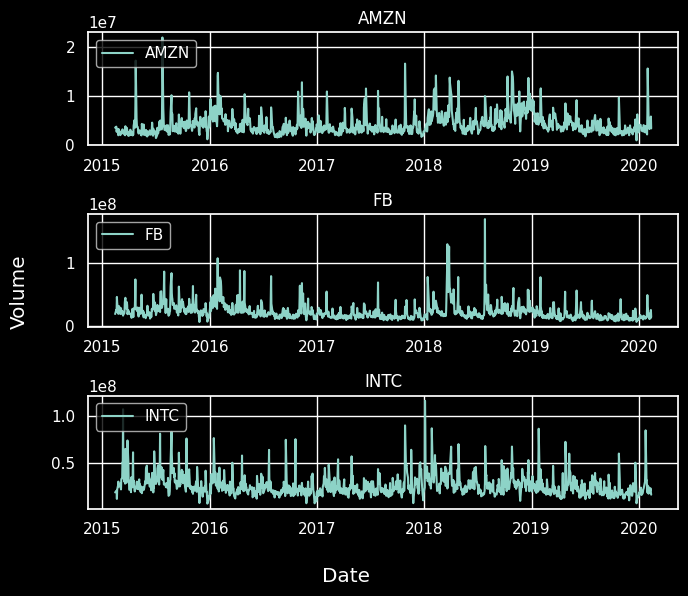

In [ ]:
# Create time series scatterplot of the trading volume of the three stocks

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 6))

data_frames = [df_amzn, df_fb, df_intc]
ticker_symbol = ['AMZN', 'FB', 'INTC']

for ax, df, label in zip([ax1, ax2, ax3], data_frames, ticker_symbol):
    ax.plot(df.groupby('Date')['Volume'].sum(), label=label)
    ax.set_title(label)
    ax.legend(loc='upper left')

fig.supxlabel('Date')
fig.supylabel('Volume')

plt.tight_layout()

## Regression on the return of the 3 stocks

In [ ]:
# Create the return column based on adjacent adj. close prices
df_amzn['Return'] = df_amzn['Adj Close'] / df_amzn['Adj Close'].shift() - 1
df_fb['Return'] = df_fb['Adj Close'] / df_fb['Adj Close'].shift() - 1
df_intc['Return'] = df_intc['Adj Close'] / df_intc['Adj Close'].shift() - 1

# Create new dataframe for correlation check
df_return = pd.merge(df_amzn['Return'], df_fb['Return'], on='Date', how='outer')
df_return = pd.merge(df_return, df_intc['Return'], on='Date', how='outer')

df_return.columns = ['AMZN_return', 'FB_return', 'INTC_return']
df_return.dropna(inplace=True)

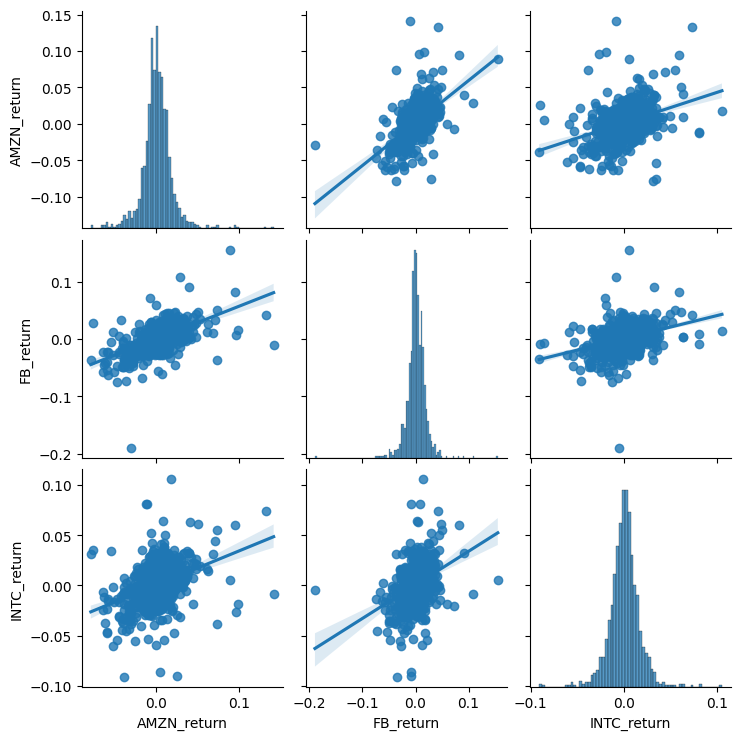

In [ ]:
# Create scatterplots about the inter-relationship of the three stock returns
plt.style.use('default')
sns.pairplot(df_return, kind='reg')

## Correlation of the return of 3 stocks using heatmap

Text(0.5, 1.0, 'Correlation of stock return')

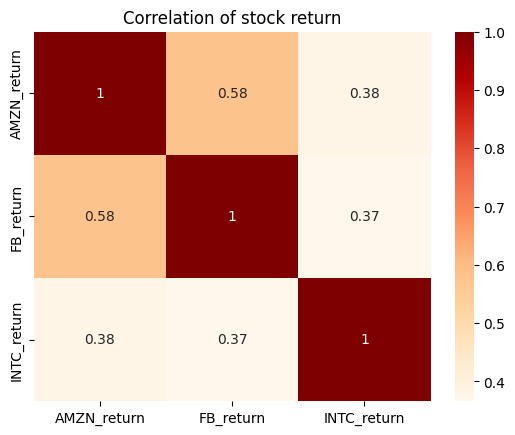

In [ ]:
# Create a heatmap representing the correlations between the three stock returns
sns.heatmap(df_return.corr(), annot=True, cmap='OrRd')
plt.title('Correlation of stock return')

# Refining Dataset

## Labelling and Standardizing

In [ ]:
# Create the return column based on adjacent adj. close prices
df_amzn['Return'] = df_amzn['Adj Close'] / df_amzn['Adj Close'].shift() - 1
df_fb['Return'] = df_fb['Adj Close'] / df_fb['Adj Close'].shift() - 1
df_intc['Return'] = df_intc['Adj Close'] / df_intc['Adj Close'].shift() - 1

In [ ]:
# Label positive returns as 1 and 0 otherwise
df_amzn['Label'] = np.where(df_amzn['Return'] > 0, 1, 0)
df_fb['Label'] = np.where(df_fb['Return'] > 0, 1, 0)
df_intc['Label'] = np.where(df_intc['Return'] > 0, 1, 0)

In [ ]:
# Standarize returns and volumes (using a rolling window of 50 days)
df_amzn["std_r"] = (df_amzn["Return"] - df_amzn["Return"][:val_start_date].mean()) / df_amzn["Return"][:val_start_date].std()
df_amzn["std_vol"] = (df_amzn["Volume"] - df_amzn["Volume"].rolling(50).mean()) / df_amzn["Volume"].rolling(50).std()

df_fb["std_r"] = (df_fb["Return"] - df_fb["Return"][:val_start_date].mean()) / df_fb["Return"][:val_start_date].std()
df_fb["std_vol"] = (df_fb["Volume"] - df_fb["Volume"].rolling(50).mean()) / df_fb["Volume"].rolling(50).std()

df_intc["std_r"] = (df_intc["Return"] - df_intc["Return"][:val_start_date].mean()) / df_intc["Return"][:val_start_date].std()
df_intc["std_vol"] = (df_intc["Volume"] - df_intc["Volume"].rolling(50).mean()) / df_intc["Volume"].rolling(50).std()

In [ ]:
# Drop NAs
df_amzn.dropna(inplace = True)
df_fb.dropna(inplace = True)
df_intc.dropna(inplace = True)

In [ ]:
# Check the resultant df
df_fb.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Label,std_r,std_vol
Date,,,,,,,,,,
2015-04-27,81.870003,82.930000,81.629997,81.910004,81.910004,25446000,0.004661,1,0.216846,-0.085915
2015-04-28,81.830002,81.900002,80.230003,80.680000,80.680000,23775300,-0.015017,0,-1.068915,-0.254491
2015-04-29,80.010002,81.389999,79.519997,80.470001,80.470001,26430300,-0.002603,0,-0.257783,-0.005027
2015-04-30,80.010002,80.959999,78.320000,78.769997,78.769997,28999000,-0.021126,0,-1.468115,0.226284
2015-05-01,79.239998,79.760002,78.110001,78.989998,78.989998,24136400,0.002793,1,0.094789,-0.201021


## Merging the three datasets

In [ ]:
# Add suffix to respective df, prepare for merging the dfs
df_amzn = df_amzn.add_suffix('_amzn')
df_fb = df_fb.add_suffix('_fb')
df_intc = df_intc.add_suffix('_intc')

In [ ]:
# Show the resultant df
df_intc.head()

,Open_intc,High_intc,Low_intc,Close_intc,Adj Close_intc,Volume_intc,Return_intc,Label_intc,std_r_intc,std_vol_intc
Date,,,,,,,,,,
2015-04-27,32.080002,32.689999,32.080002,32.500000,28.331215,25869600,0.013092,1,0.924372,-0.396081
2015-04-28,32.299999,33.040001,32.230000,33.020000,28.784515,29572800,0.016000,1,1.139287,-0.190070
2015-04-29,32.560001,33.000000,32.549999,32.889999,28.671192,21819000,-0.003937,0,-0.334177,-0.661090
2015-04-30,32.709999,32.849998,32.299999,32.549999,28.374804,22013300,-0.010337,0,-0.807217,-0.652965
2015-05-01,32.630001,33.490002,32.619999,33.419998,29.133207,27091200,0.026728,1,1.932154,-0.371837


In [ ]:
# Create a merged df with relevant features (standardized return, standardized volume and Labels)

from functools import reduce
df_list = [df_amzn[["std_r_amzn","std_vol_amzn","Label_amzn"]][:], df_fb[["std_r_fb","std_vol_fb","Label_fb"]][:], df_intc[["std_r_intc","std_vol_intc","Label_intc"]][:]]

df_merged = df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), df_list)

# Show the resultant df
df_merged.head()

,std_r_amzn,std_vol_amzn,Label_amzn,std_r_fb,std_vol_fb,Label_fb,std_r_intc,std_vol_intc,Label_intc
Date,,,,,,,,,
2015-04-27,-0.945425,0.998142,0,0.216846,-0.085915,1,0.924372,-0.396081,1
2015-04-28,-1.313774,0.429387,0,-1.068915,-0.254491,0,1.139287,-0.190070,1
2015-04-29,-0.091499,0.204200,1,-0.257783,-0.005027,0,-0.334177,-0.661090,0
2015-04-30,-1.117193,0.206930,0,-1.468115,0.226284,0,-0.807217,-0.652965,0
2015-05-01,0.049230,0.165858,1,0.094789,-0.201021,1,1.932154,-0.371837,1


## Creating TS Generators

In [ ]:
# Get index for val_start_date and test_start_date
val_start_iloc = df_merged.index.get_indexer([val_start_date], method='bfill')[0]
test_start_iloc = df_merged.index.get_indexer([test_start_date], method='bfill')[0]

In [ ]:
# Check the index
test_start_iloc

928

## Extracting Relevant Features and Labels

In [ ]:
# Extract relevant features as X
X = df_merged[["std_r_amzn", "std_vol_amzn", "std_r_fb", "std_vol_fb", "std_r_intc", "std_vol_intc"]].values

# Extract FB Labels as y
y = df_merged[["Label_fb"]].values

# Create train, test, val split
X_train, X_val, X_test = X[:val_start_iloc], X[val_start_iloc:test_start_iloc], X[test_start_iloc:]
y_train, y_val, y_test = y[:val_start_iloc], y[val_start_iloc:test_start_iloc], y[test_start_iloc:]

In [ ]:
# Create generators for training, validation and testing
train_generator = TimeseriesGenerator(X_train, y_train, length = 21, batch_size = 64)
val_generator  = TimeseriesGenerator(X_val, y_val, length = 21, batch_size = 64)
test_generator = TimeseriesGenerator(X_test, y_test, length = 21, batch_size = 64)

# Building Model

## Building NN Archetecture (LSTM Model)

In [ ]:
# 1 neuron in dense layer, activation function is sigmoid
model_used = "10s10s1r"

In [ ]:
# Create NN structure

# Available metrics are: loss,accuracy,val_loss,val_accuracy
# Define the model structure and parameters
def model_fn(params):

    model = tf.keras.Sequential()
    # Input layer
    model.add(tf.keras.layers.LSTM(params["lstm_size"], input_shape = (21, 6))) # Here we use 6 features for each of the past 21 observations
    model.add(tf.keras.layers.Dropout(params["dropout"]))
    model.add(tf.keras.layers.Dense(10, activation = "sigmoid")) # alter and tried different combinations of layer and activation functions
    model.add(tf.keras.layers.Dense(10, activation = "sigmoid"))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation = "relu"))


    model.compile(optimizer = tf.keras.optimizers.Adam(params["learning_rate"]),
                  loss = "binary_crossentropy", metrics = ["accuracy"])

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 5,
                                                  restore_best_weights = True)]
    history   = model.fit_generator(train_generator, validation_data = val_generator,
                                  callbacks = callbacks, epochs = 100, verbose = 0).history
    return (history, model)

## Cross-Validation

### Random Search

In [ ]:
# Cross Validation for NN
# Define the radom_search function for Cross validation later
def random_search(model_fn, search_space, n_iter, search_dir):

    results = [] # initialise an empty set

    os.mkdir(search_dir) # use os and create a directory

    best_model_path = os.path.join(search_dir, "best_model.h5")
    results_path    = os.path.join(search_dir, "results.csv")

    for i in range(n_iter):

        # create a dictionary saying that params are lstm_size:, dropout:, learning rate:
        params           = {k: v[np.random.randint(len(v))] for k, v in search_space.items()}
        history, model   = model_fn(params)
        epochs           = np.argmax(history["val_accuracy"]) + 1
        result           = {k: v[epochs - 1] for k, v in history.items()}
        params["epochs"] = epochs

        if i == 0:
            best_val_acc = result["val_accuracy"]
            model.save(best_model_path)

        if result["val_accuracy"] > best_val_acc:
            best_val_acc = result["val_accuracy"]
            model.save(best_model_path)

        result = {**params, **result}
        results.append(result)
        tf.keras.backend.clear_session()
        print(f"iteration {i + 1} – {', '.join(f'{k}:{v:.4g}' for k, v in result.items())}")

    best_model = tf.keras.models.load_model(best_model_path)
    results    = pd.DataFrame(results)

    results.to_csv(results_path)

    return (results, best_model)

In [ ]:
# CV parameters
search_space = {"lstm_size":     np.linspace(50, 200, 5, dtype = int),
                "dropout":       np.linspace(0, 0.4, 2),
                "learning_rate": np.linspace(0.004, 0.01, 4)}

In [ ]:
import os, shutil

# Delete the directory is search_new exists
if os.path.isdir("search_new"):
    shutil.rmtree("search_new")

# Do a 10-iteration CV with random parameters from search_space
# Select the best model as the one giving the max val_acc
iterations = 10
results, best_model = random_search(model_fn, search_space, iterations, "search_new")

<ipython-input-31-fb34cf562b03>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history   = model.fit_generator(train_generator, validation_data = val_generator,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


iteration 1 – lstm_size:50, dropout:0.4, learning_rate:0.008, epochs:1, loss:6.847, accuracy:0.551, val_loss:7.591, val_accuracy:0.5022
iteration 2 – lstm_size:162, dropout:0, learning_rate:0.006, epochs:1, loss:8.499, accuracy:0.449, val_loss:7.746, val_accuracy:0.4978
iteration 3 – lstm_size:50, dropout:0, learning_rate:0.006, epochs:1, loss:0.7106, accuracy:0.5145, val_loss:0.6917, val_accuracy:0.5459
iteration 4 – lstm_size:162, dropout:0, learning_rate:0.006, epochs:1, loss:8.499, accuracy:0.449, val_loss:7.746, val_accuracy:0.4978
iteration 5 – lstm_size:162, dropout:0.4, learning_rate:0.01, epochs:1, loss:6.847, accuracy:0.551, val_loss:7.591, val_accuracy:0.5022
iteration 6 – lstm_size:50, dropout:0.4, learning_rate:0.008, epochs:1, loss:8.499, accuracy:0.449, val_loss:7.746, val_accuracy:0.4978
iteration 7 – lstm_size:50, dropout:0, learning_rate:0.01, epochs:5, loss:0.6756, accuracy:0.5875, val_loss:0.6977, val_accuracy:0.5371
iteration 8 – lstm_size:125, dropout:0.4, learnin

In [ ]:
# Get sorted results based on val_accuracy
results.sort_values("val_accuracy", ascending = False)

,lstm_size,dropout,learning_rate,epochs,loss,accuracy,val_loss,val_accuracy
2,50,0.0,0.006,1,0.710570,0.514460,0.691656,0.545852
6,50,0.0,0.010,5,0.675649,0.587519,0.697720,0.537118
0,50,0.4,0.008,1,6.847071,0.550989,7.591324,0.502183
4,162,0.4,0.010,1,6.847071,0.550989,7.591324,0.502183
1,162,0.0,0.006,1,8.498981,0.449011,7.746153,0.497817
3,162,0.0,0.006,1,8.498981,0.449011,7.746153,0.497817
5,50,0.4,0.008,1,8.498982,0.449011,7.746153,0.497817
7,125,0.4,0.008,1,8.498981,0.449011,7.746153,0.497817
8,50,0.4,0.010,1,8.498981,0.449011,7.746153,0.497817
9,200,0.4,0.010,1,8.498982,0.449011,7.746153,0.497817


Highest val_accuracy = 0.545852

#### Testing Model

In [ ]:
# Create predictions by fitting testing data to the best model
best_model.evaluate_generator(test_generator)

<ipython-input-36-b46a3b1b6dea>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  best_model.evaluate_generator(test_generator)


[0.6968531608581543, 0.4769230782985687]

### Grid Search

In [ ]:
import itertools

def grid_search(model_fn, search_space, search_dir):
    results = []

    # Create all possible combinations of hyperparameters
    hyperparam_combinations = list(itertools.product(*search_space.values()))

    # Create a directory for saving results
    os.makedirs(search_dir, exist_ok=True)

    for i, params_values in enumerate(hyperparam_combinations):
        params = {k: v for k, v in zip(search_space.keys(), params_values)}

        # Call model_fn with the current set of parameters
        history, model = model_fn(params)

        # Get the epoch with the highest validation accuracy
        epochs = np.argmax(history["val_accuracy"]) + 1

        # Create a dictionary with hyperparameters and corresponding results
        result = {k: v[epochs - 1] for k, v in history.items()}
        result.update(params)  # Add hyperparameters to the result

        # Save the model if it has the best validation accuracy
        if i == 0 or result["val_accuracy"] > best_val_acc:
            best_val_acc = result["val_accuracy"]
            best_model_path = os.path.join(search_dir, "best_model.h5")
            model.save(best_model_path)

        results.append(result)  # Append the result to the list
        tf.keras.backend.clear_session()

        print(f"Iteration {i + 1} – {', '.join(f'{k}:{v:.4g}' for k, v in result.items())}")

    # Load the best model
    best_model = tf.keras.models.load_model(best_model_path)

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_path = os.path.join(search_dir, "results.csv")
    results_df.to_csv(results_path, index=False)

    return results_df, best_model

search_space = {
    "lstm_size": np.linspace(50, 200, 5, dtype=int),
    "dropout": np.linspace(0, 0.4, 2),
    "learning_rate": np.linspace(0.004, 0.01, 4)
}

results_df, best_model = grid_search(model_fn, search_space, "grid_search_results")

<ipython-input-31-fb34cf562b03>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history   = model.fit_generator(train_generator, validation_data = val_generator,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Iteration 1 – loss:8.499, accuracy:0.449, val_loss:7.746, val_accuracy:0.4978, lstm_size:50, dropout:0, learning_rate:0.004
Iteration 2 – loss:0.8672, accuracy:0.481, val_loss:0.7638, val_accuracy:0.5022, lstm_size:50, dropout:0, learning_rate:0.006
Iteration 3 – loss:0.6393, accuracy:0.6393, val_loss:0.7501, val_accuracy:0.5371, lstm_size:50, dropout:0, learning_rate:0.008
Iteration 4 – loss:8.499, accuracy:0.449, val_loss:7.746, val_accuracy:0.4978, lstm_size:50, dropout:0, learning_rate:0.01
Iteration 5 – loss:8.499, accuracy:0.449, val_loss:7.746, val_accuracy:0.4978, lstm_size:50, dropout:0.4, learning_rate:0.004
Iteration 6 – loss:8.499, accuracy:0.449, val_loss:7.746, val_accuracy:0.4978, lstm_size:50, dropout:0.4, learning_rate:0.006
Iteration 7 – loss:0.6372, accuracy:0.6195, val_loss:0.7807, val_accuracy:0.559, lstm_size:50, dropout:0.4, learning_rate:0.008
Iteration 8 – loss:6.847, accuracy:0.551, val_loss:7.591, val_accuracy:0.5022, lstm_size:50, dropout:0.4, learning_rate:

In [ ]:
# Get sorted results based on val_accuracy
results_df.sort_values("val_accuracy", ascending = False)

,loss,accuracy,val_loss,val_accuracy,lstm_size,dropout,learning_rate
6,0.637188,0.619483,0.780670,0.558952,50,0.4,0.008
14,0.577287,0.697108,0.809554,0.554585,87,0.4,0.008
22,0.668091,0.601218,0.721619,0.554585,125,0.4,0.008
25,0.678447,0.578387,0.691258,0.550218,162,0.0,0.006
23,0.677495,0.596651,0.737549,0.541485,125,0.4,0.010
34,0.701975,0.525114,0.684675,0.541485,200,0.0,0.008
2,0.639345,0.639269,0.750053,0.537118,50,0.0,0.008
35,0.636971,0.654490,0.798061,0.537118,200,0.0,0.010
10,0.649934,0.607306,0.752107,0.537118,87,0.0,0.008
12,0.729732,0.555556,0.703432,0.532751,87,0.4,0.004


Highest val_accuracy = 0.558952

#### Testing Model

In [ ]:
# Create predictions by fitting testing data to the best model
best_model.evaluate_generator(test_generator)

<ipython-input-39-b46a3b1b6dea>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  best_model.evaluate_generator(test_generator)


[0.7111549377441406, 0.550000011920929]

# Model Evalution

## Model Summary

In [ ]:
# Show model summary (architecture)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 12031 (47.00 KB)
Trainable params: 12031 (47.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model Results

In [ ]:
# get the predicted probability
pred = best_model.predict(test_generator)

# set decision threshold
decision = 0.5

# label the predictions based on the threshold
# Label as 1 if the predicted probability > decision threshold, 0 if otherwise
y_pred = (pred > decision).astype(int)

5/5 [==============================] - 1s 6ms/step


In [ ]:
# Transform np.ndarray into list
pred = [x[0] for x in pred]
y_pred = [x[0] for x in y_pred]

# Create a dataframe with Probability and prediction (0 or 1)
df_pred = pd.DataFrame({"Prob":pred, "Predict":y_pred})

# Extract the date for testing set
index_date = df_merged.index[test_start_iloc+21::]
df_index = pd.DataFrame({"Date":index_date})

list_df = [df_index, df_pred]
df_new = pd.concat(list_df, axis=1)
df_new.set_index("Date", inplace=True)

# Create a df containing the test label, predicted label and corresponding probability, with Date as index
df_results = pd.merge(df_merged[["Label_fb"]],df_new, left_index=True, right_index=True)
df_results.head()

,Label_fb,Prob,Predict
Date,,,
2019-02-01,0,0.614316,1
2019-02-04,1,0.391032,0
2019-02-05,1,0.197338,0
2019-02-06,0,0.123474,0
2019-02-07,0,0.169378,0


## Classification Report and Confusion Matrix

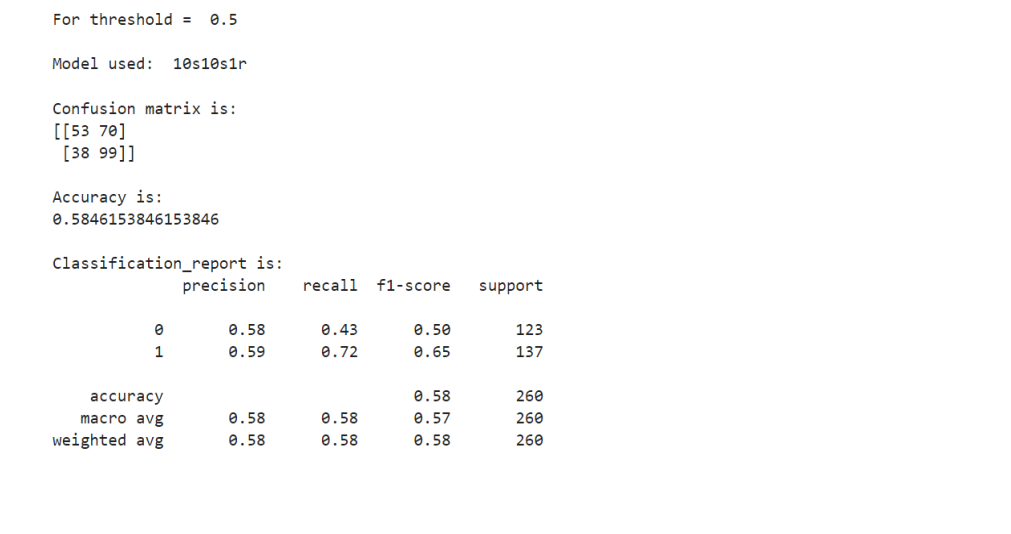

In [ ]:
# Import relevant evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_true = df_results["Label_fb"]
y_predict = df_results["Predict"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_predict)
ac = accuracy_score(y_true, y_predict)

print("For threshold = ", decision)
print("\nModel used: ", model_used)
print("\nConfusion matrix is: ")
print(cm)
print("\nAccuracy is: ")
print(ac)
print("\nClassification_report is: ")
print(classification_report(y_true, y_predict))

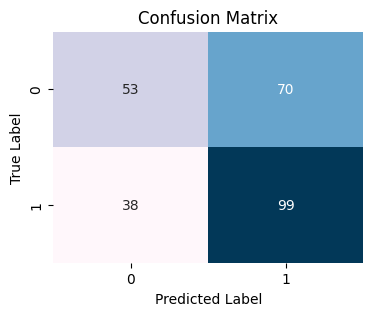

In [ ]:
# Plotting confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="PuBu", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Alternative Models (for Comparision)

## ANN model

In [ ]:
# Import libraries for building ANN model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Create an ANN model (1 input, 2 hidden, 1 output layer)
classifier = Sequential()
classifier.add(Dense(units=3.5, kernel_initializer='uniform', activation='relu', input_shape=(21, 6)))
classifier.add(Dense(units=3.5, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=3.5, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Compile the model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]

# Clear backend session
tf.keras.backend.clear_session()

# Fit the model
#history = classifier.fit(X_train, y_train, epochs=100, batch_size=64,validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)
history = classifier.fit_generator(train_generator, validation_data = val_generator, callbacks = callbacks, epochs = 100, verbose = 0).history

# Print model summary
classifier.summary()


<ipython-input-46-64ac5a395587>:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = classifier.fit_generator(train_generator, validation_data = val_generator, callbacks = callbacks, epochs = 100, verbose = 0).history


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 21, 3)             21        
                                                                 
 dense_1 (Dense)             (None, 21, 3)             12        
                                                                 
 dense_2 (Dense)             (None, 21, 3)             12        
                                                                 
 dense_3 (Dense)             (None, 21, 1)             4         
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Evaluate the model on the test data
pred = classifier.predict(test_generator) # get the predicted probability
decision = 0.5 # set decision threshold

y_pred_ann = (pred > decision).astype(int) # label the predictions based on the threshold

5/5 [==============================] - 0s 5ms/step


In [ ]:
import numpy as np

# Take the mean along the time steps axis
y_pred_mean = np.mean(y_pred_ann, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure y_test_actual has the same length as y_pred
y_test_actual = df_fb["Label_fb"].values[test_start_iloc + 21:]

# Calculate accuracy
accuracy_ann = accuracy_score(y_test_actual, y_pred_mean)
conf_matrix_ann = confusion_matrix(y_test_actual, y_pred_mean)
class_report_ann = classification_report(y_test_actual, y_pred_mean)

print("Accuracy:", accuracy_ann)
print("Confusion Matrix:")
print(conf_matrix_ann)
print("\nClassification Report:")
print(class_report_ann)

Accuracy: 0.5269230769230769
Confusion Matrix:
[[  0 123]
 [  0 137]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.53      1.00      0.69       137

    accuracy                           0.53       260
   macro avg       0.26      0.50      0.35       260
weighted avg       0.28      0.53      0.36       260



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


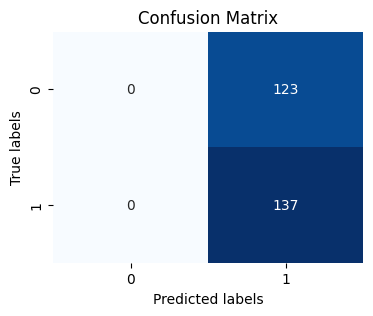

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_ann, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## RNN model

In [ ]:
def model_rnn(params):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.SimpleRNN(params["unit"], input_shape = (21, 6)))
  model.add(tf.keras.layers.Dropout(params["dropout"])) # act as a form of regularisation
  model.add(tf.keras.layers.Dense(1, activation = "sigmoid")) # use sigmoid because x is continuous

  model.compile(optimizer = tf.keras.optimizers.Adam(params["learning_rate"]),loss = "binary_crossentropy", metrics = ["accuracy"])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 5,restore_best_weights = True)]

  history = model.fit_generator(train_generator, validation_data = val_generator, callbacks = callbacks, epochs = 100, verbose = 0).history

  return (history, model)

In [ ]:
# Cross Validation in Neural Nets
def random_search_rnn(model_rnn, search_space, n_iter, search_dir):
  results = [] # initialise an empty set
  os.mkdir(search_dir) # use os and create a directory

  best_model_path = os.path.join(search_dir, "best_model.h5")
  results_path = os.path.join(search_dir, "results.csv")

  for i in range(n_iter):
    params = {k: v[np.random.randint(len(v))] for k, v in search_space.items()}
    history, model   = model_rnn(params)
    epochs           = np.argmax(history["val_accuracy"]) + 1
    result           = {k: v[epochs - 1] for k, v in history.items()}
    params["epochs"] = epochs

    if i == 0:
      best_val_acc = result["val_accuracy"]
      model.save(best_model_path)

    if result["val_accuracy"] > best_val_acc:
      best_val_acc = result["val_accuracy"]
      model.save(best_model_path)

    result = {**params, **result}
    results.append(result)
    tf.keras.backend.clear_session()
    print(f"iteration {i + 1} – {', '.join(f'{k}:{v:.4g}' for k, v in result.items())}")

  best_model = tf.keras.models.load_model(best_model_path)
  results   = pd.DataFrame(results)

  results.to_csv(results_path)

  return(results, best_model)

In [ ]:
search_space = {"unit": np.linspace(50, 200, 5, dtype = int),
                "dropout": np.linspace(0, 0.4, 2),
                "learning_rate": np.linspace(0.004, 0.01, 4)}

In [ ]:
import os, shutil

# Delete the directory is search_new exists
if os.path.isdir("search_RNN"):
    shutil.rmtree("search_RNN")

iterations = 10
results, best_model = random_search_rnn(model_rnn, search_space, iterations, "search_RNN")

<ipython-input-17-bd446ba07e52>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = val_generator, callbacks = callbacks, epochs = 100, verbose = 0).history
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


iteration 1 – unit:50, dropout:0, learning_rate:0.01, epochs:6, loss:0.6138, accuracy:0.6651, val_loss:0.7271, val_accuracy:0.5677
iteration 2 – unit:50, dropout:0.4, learning_rate:0.006, epochs:7, loss:0.5614, accuracy:0.7184, val_loss:0.7369, val_accuracy:0.559
iteration 3 – unit:50, dropout:0.4, learning_rate:0.01, epochs:5, loss:0.6213, accuracy:0.6697, val_loss:0.7276, val_accuracy:0.5764
iteration 4 – unit:162, dropout:0, learning_rate:0.01, epochs:6, loss:0.679, accuracy:0.5495, val_loss:0.671, val_accuracy:0.5895
iteration 5 – unit:125, dropout:0.4, learning_rate:0.01, epochs:2, loss:0.7524, accuracy:0.5251, val_loss:0.6794, val_accuracy:0.5764
iteration 6 – unit:162, dropout:0, learning_rate:0.006, epochs:1, loss:0.8348, accuracy:0.519, val_loss:0.7386, val_accuracy:0.5328
iteration 7 – unit:125, dropout:0.4, learning_rate:0.01, epochs:12, loss:0.6892, accuracy:0.5662, val_loss:0.6834, val_accuracy:0.5808
iteration 8 – unit:200, dropout:0.4, learning_rate:0.01, epochs:11, loss

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 162)               27378     
                                                                 
 dropout (Dropout)           (None, 162)               0         
                                                                 
 dense (Dense)               (None, 1)                 163       
                                                                 
Total params: 27541 (107.58 KB)
Trainable params: 27541 (107.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Create predictions by fitting testing data to the best model
best_model.evaluate_generator(test_generator)

<ipython-input-40-b46a3b1b6dea>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  best_model.evaluate_generator(test_generator)


[0.7026224136352539, 0.5423076748847961]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Get prediction probability
y_prob = best_model.predict(test_generator)
# Label as 1 if probaility > 0.5
y_pred = (y_prob > 0.5).astype(int)

# Ensure y_test_actual has the same length as y_pred
y_test_actual = df_fb["Label_fb"].values[test_start_iloc + 21:]

# Compute the confusion matrix
accuracy_rnn = accuracy_score(y_test_actual, y_pred)
conf_matrix_rnn = confusion_matrix(y_test_actual, y_pred)
class_report_rnn = classification_report(y_test_actual, y_pred)

print("Accuracy:", accuracy_rnn)
print("Confusion Matrix:")
print(conf_matrix_rnn)
print("\nClassification Report:")
print(class_report_rnn)

5/5 [==============================] - 0s 21ms/step
Accuracy: 0.5423076923076923
Confusion Matrix:
[[54 69]
 [50 87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.44      0.48       123
           1       0.56      0.64      0.59       137

    accuracy                           0.54       260
   macro avg       0.54      0.54      0.53       260
weighted avg       0.54      0.54      0.54       260



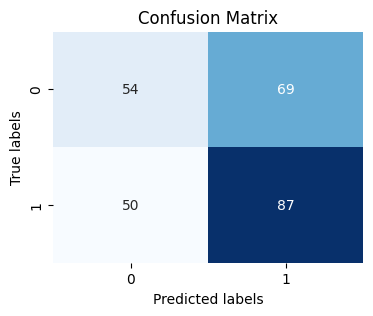

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_rnn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()